In [0]:
pip install eurostat

  Obtaining dependency information for eurostat from https://files.pythonhosted.org/packages/51/a0/51b4254341558a69002100e1bc9df436c000e03a1ae3488b7e431c61b890/eurostat-1.1.1-py3-none-any.whl.metadata
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


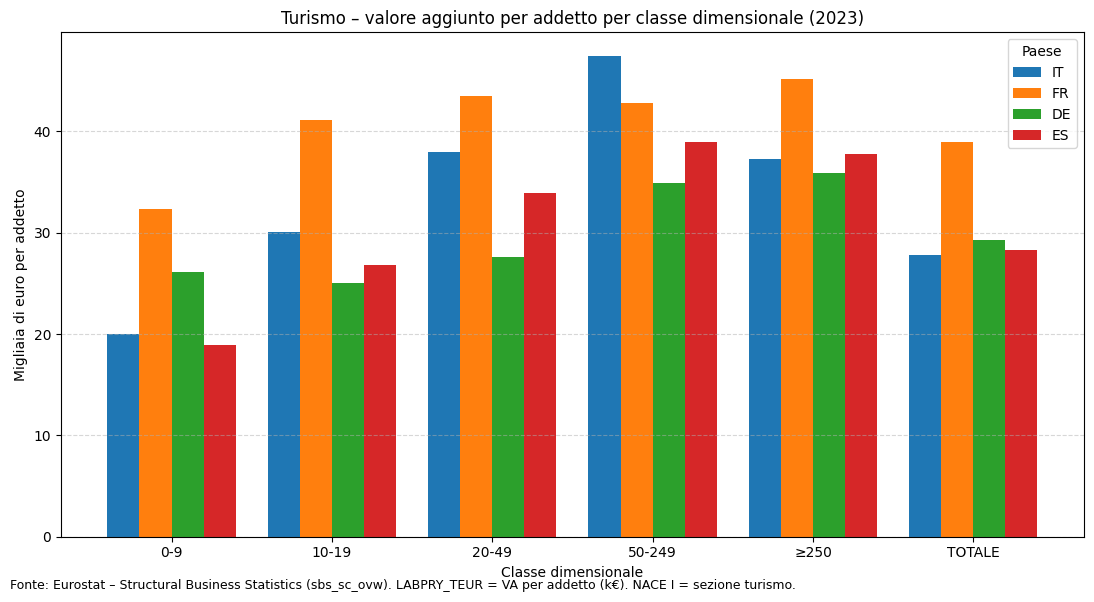

In [0]:
# -*- coding: utf-8 -*-
import eurostat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATASET   = "sbs_sc_ovw"
countries = ["IT", "FR", "DE", "ES"]
size_order = ["0-9", "10-19", "20-49", "50-249", "GE250", "TOTAL"]
geo_col = "geo\\TIME_PERIOD"

IND_LAB = "LABPRY_TEUR"  # VA per addetto (k€), medio (non additivo)
NACE_I  = "I"             # Turismo: sezione I (aggregato corretto)

df = eurostat.get_data_df(DATASET)
year_cols = [c for c in df.columns if c.isdigit() and len(c) == 4]
year_cols.sort()
year = year_cols[-1]  # ultimo anno disponibile (es. 2023)

base = df[
    (df[geo_col].isin(countries)) &
    (df["nace_r2"] == NACE_I) &
    (df["size_emp"].isin(size_order)) &
    (df["indic_sbs"] == IND_LAB)
].copy()

base[year] = pd.to_numeric(base[year], errors="coerce")
base["size_emp"] = pd.Categorical(base["size_emp"], categories=size_order, ordered=True)

pivot_lab = base.pivot(index="size_emp", columns=geo_col, values=year).loc[size_order, countries]
pivot_lab = pivot_lab.rename(index={"GE250": "≥250", "TOTAL": "TOTALE"})

# --- grafico a barre raggruppate ---
X = np.arange(len(pivot_lab.index))
m = len(pivot_lab.columns)
width = 0.8 / m

fig, ax = plt.subplots(figsize=(11, 6))
for j, col in enumerate(pivot_lab.columns):
    ax.bar(X + (j - (m-1)/2)*width, pivot_lab[col].values, width, label=col)

ax.set_xticks(X)
ax.set_xticklabels(pivot_lab.index)
ax.set_ylabel("Migliaia di euro per addetto")
ax.set_xlabel("Classe dimensionale")
ax.set_title(f"Turismo – valore aggiunto per addetto per classe dimensionale ({year})")
ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.legend(title="Paese")
fig.tight_layout()
fig.text(0.01, 0.01,
         "Fonte: Eurostat – Structural Business Statistics (sbs_sc_ovw). "
         "LABPRY_TEUR = VA per addetto (k€). NACE I = sezione turismo.",
         ha="left", fontsize=9)
plt.show()


In [0]:
# -*- coding: utf-8 -*-
import eurostat
import pandas as pd

DATASET = "sbs_sc_ovw"
GEO_COL = "geo\\TIME_PERIOD"
YEAR = "2023"
NACE_TOURISM = "I"        # Sezione I = turismo
INDICATOR = "LABPRY_TEUR" # VA per addetto (migliaia di euro)
SIZE_ORDER = ["0-9", "10-19", "20-49", "50-249", "GE250", "TOTAL"]

# 1) Carica dati
df = eurostat.get_data_df(DATASET)

# 2) Filtra Italia, Turismo, indicatore VA/addetto
f = (
    (df[GEO_COL] == "IT") &
    (df["nace_r2"] == NACE_TOURISM) &
    (df["indic_sbs"] == INDICATOR) &
    (df["size_emp"].isin(SIZE_ORDER))
)

it_tourism = df.loc[f, ["size_emp", YEAR]].copy()

# 3) Conversione numerica e ordinamento
it_tourism[YEAR] = pd.to_numeric(it_tourism[YEAR], errors="coerce")
it_tourism["size_emp"] = pd.Categorical(it_tourism["size_emp"], categories=SIZE_ORDER, ordered=True)
it_tourism = it_tourism.sort_values("size_emp").set_index("size_emp")

# 4) Rinomina GE250
it_tourism = it_tourism.rename(index={"GE250": "≥250"})

# 5) Stampa i dati grezzi
print("Valore aggiunto per addetto (Italia, Turismo, anno", YEAR, "):")
print(it_tourism)

# 6) Stampa anche un confronto con l’economia totale
f2 = (
    (df[GEO_COL] == "IT") &
    (df["nace_r2"] == "B-S_X_O_S94") & # totale economia
    (df["indic_sbs"] == INDICATOR) &
    (df["size_emp"].isin(SIZE_ORDER))
)
it_total = df.loc[f2, ["size_emp", YEAR]].copy()
it_total[YEAR] = pd.to_numeric(it_total[YEAR], errors="coerce")
it_total["size_emp"] = pd.Categorical(it_total["size_emp"], categories=SIZE_ORDER, ordered=True)
it_total = it_total.sort_values("size_emp").set_index("size_emp").rename(index={"GE250": "≥250"})

print("\nValore aggiunto per addetto (Italia, Totale economia, anno", YEAR, "):")
print(it_total)


Valore aggiunto per addetto (Italia, Turismo, anno 2023 ):
           2023
size_emp       
0-9       19.98
10-19     30.12
20-49     37.99
50-249    47.41
≥250      37.28
TOTAL     27.81

Valore aggiunto per addetto (Italia, Totale economia, anno 2023 ):
           2023
size_emp       
0-9       38.83
10-19     54.92
20-49     65.44
50-249    80.62
≥250      95.50
TOTAL     63.22


Confronto settori – Italia, 2023
Settore
Energia                  385.67
Farmaceutica             167.80
Chimica                  121.44
Automotive               113.45
Aerospazio/trasporti     103.14
Elettronica               89.85
ICT                       85.00
Ricerca scientifica       75.58
Media nazionale           63.22
Servizi professionali     52.69
Turismo                   27.81
Name: 2023, dtype: float64


/home/spark-0e7d0bd7-4c01-424a-aad2-33/.ipykernel/7287/command-7174367388042308-3478407823:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(res.index, rotation=45, ha="right")


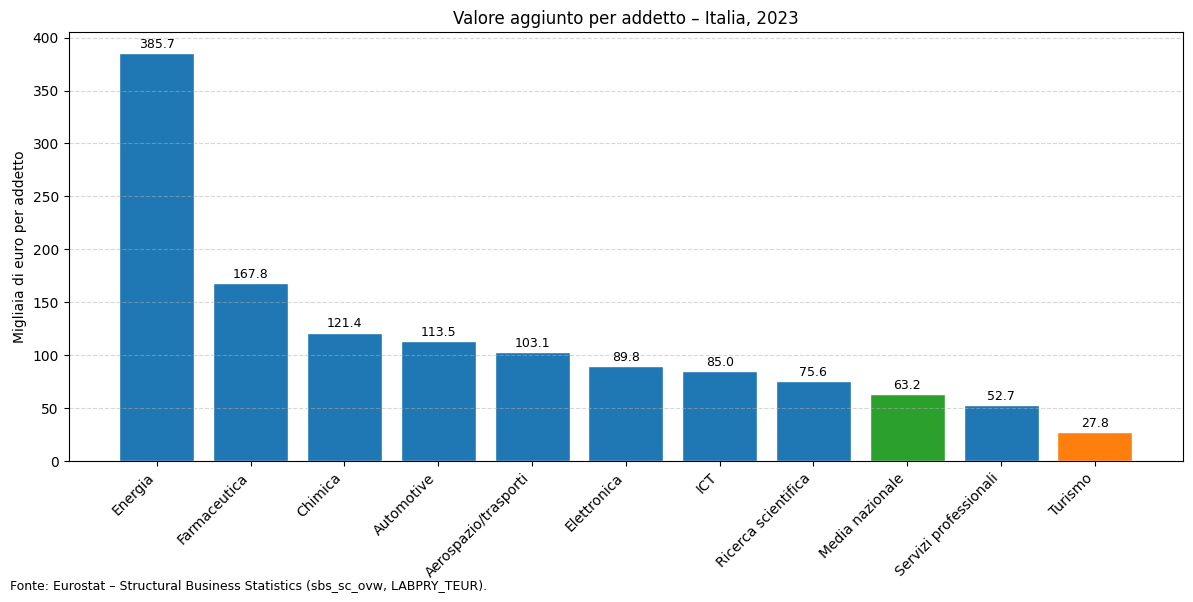

In [0]:
# -*- coding: utf-8 -*-
import eurostat
import pandas as pd
import matplotlib.pyplot as plt

DATASET = "sbs_sc_ovw"
GEO_COL = "geo\\TIME_PERIOD"
YEAR = "2023"
INDICATOR = "LABPRY_TEUR"  # Valore aggiunto per addetto (k€)

# Settori selezionati
sectors = {
    "I": "Turismo",
    "D": "Energia",
    "C20": "Chimica",
    "C21": "Farmaceutica",
    "C26": "Elettronica",
    "C29": "Automotive",
    "C30": "Aerospazio/trasporti",
    "J": "ICT",
    "M72": "Ricerca scientifica",
    "M69": "Servizi professionali"
}

# Scarica dati da Eurostat
df = eurostat.get_data_df(DATASET)

# Filtro Italia e indicatori
base = df[
    (df[GEO_COL] == "IT") &
    (df["indic_sbs"] == INDICATOR) &
    (df["nace_r2"].isin(sectors.keys())) &
    (df["size_emp"] == "TOTAL")
].copy()

base[YEAR] = pd.to_numeric(base[YEAR], errors="coerce")
base["Settore"] = base["nace_r2"].map(sectors)

# Media nazionale (totale economia)
totale = df[
    (df[GEO_COL] == "IT") &
    (df["indic_sbs"] == INDICATOR) &
    (df["nace_r2"] == "B-S_X_O_S94") &
    (df["size_emp"] == "TOTAL")
].copy()
totale[YEAR] = pd.to_numeric(totale[YEAR], errors="coerce")
media_val = float(totale[YEAR].iloc[0])

# Usa concat invece di append
extra = pd.DataFrame([{"Settore": "Media nazionale", YEAR: media_val}])
base = pd.concat([base[["Settore", YEAR]], extra], ignore_index=True)

# Risultati ordinati
res = base.dropna(subset=[YEAR]).set_index("Settore")[YEAR].sort_values(ascending=False)

print("Confronto settori – Italia,", YEAR)
print(res)

# Grafico
fig, ax = plt.subplots(figsize=(12,6))
colors = [
    "#ff7f0e" if s == "Turismo" else
    "#2ca02c" if s == "Media nazionale" else
    "#1f77b4"
    for s in res.index
]

bars = ax.bar(res.index, res.values, color=colors, edgecolor="white")

# Etichette valori
for b, v in zip(bars, res.values):
    ax.text(b.get_x() + b.get_width()/2, v + 2, f"{v:.1f}", ha="center", va="bottom", fontsize=9)

ax.set_title(f"Valore aggiunto per addetto – Italia, {YEAR}")
ax.set_ylabel("Migliaia di euro per addetto")
ax.set_xticklabels(res.index, rotation=45, ha="right")
ax.grid(axis="y", linestyle="--", alpha=0.5)
fig.tight_layout()
fig.text(0.01, 0.01,
         "Fonte: Eurostat – Structural Business Statistics (sbs_sc_ovw, LABPRY_TEUR).",
         ha="left", fontsize=9)

plt.show()


=== Diagnostica: nama_10_a64 (Valore aggiunto) – IT, settori selezionati ===
na_item disponibili: ['B1G']
unit disponibili: ['CLV05_MEUR', 'CLV05_MNAC', 'CLV10_MEUR', 'CLV10_MNAC', 'CLV15_MEUR', 'CLV15_MNAC', 'CLV20_MEUR', 'CLV20_MNAC', 'CLV_I10', 'CLV_I15', 'CLV_I20', 'CLV_PCH_PRE', 'CP_MEUR', 'CP_MNAC', 'PC_TOT', 'PD10_EUR', 'PD10_NAC', 'PD15_NAC', 'PD20_NAC', 'PD_PCH_PRE_EUR'] ...

=== Diagnostica: nama_10_a64_e (Occupati) – IT, settori selezionati ===
na_item (atteso EMP_DC): ['EMP_DC']
unit disponibili: ['PCH_PRE_HW', 'PCH_PRE_JOB', 'PCH_PRE_PER', 'THS_HW', 'THS_JOB', 'THS_PER']

Confronto settori – Italia, 2023 (Conti nazionali)
Settore
Energia                327.5
Farmaceutica           185.4
Ricerca scientifica    144.6
Chimica                117.0
Elettronica            115.7
ICT                     93.8
Media nazionale         73.4
Turismo                 44.6
Name: va_per_addetto_kEUR, dtype: float64


/home/spark-0e7d0bd7-4c01-424a-aad2-33/.ipykernel/7287/command-7174367388042478-147778751:133: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(res.index, rotation=35, ha="right")


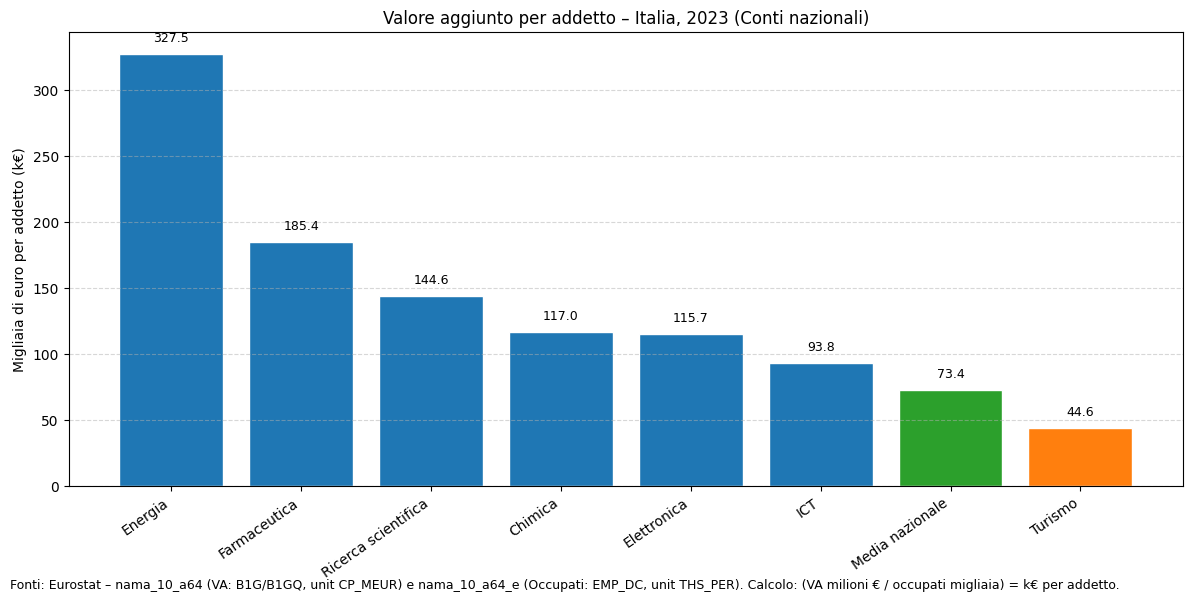

In [0]:
# Fonti: Eurostat – Conti nazionali
# - Valore aggiunto: nama_10_a64 (na_item=B1G/B1GQ; unit preferite: CP_MEUR/MIO_EUR)
# - Occupati: nama_10_a64_e (na_item=EMP_DC; unit preferite: THS_PER)
#
# Calcolo: k€ per addetto = (VA_milioni_euro / Occupati_migliaia)
# N.B. Questo script è robusto: stampa prima la struttura (na_item, unit) realmente disponibili
# per Italia e settori, poi seleziona la miglior combinazione possibile.

import eurostat
import pandas as pd
import matplotlib.pyplot as plt

COUNTRY = "IT"
YEAR_TARGET = 2023  # user target (se non disponibile, prende l'ultimo <= target)

# Settori da mostrare (NACE Rev.2)
SECTORS = {
    "I":   "Turismo",
    "D":   "Energia",
    "C20": "Chimica",
    "C21": "Farmaceutica",
    "C26": "Elettronica",
    "C29": "Automotive",
    "C30": "Aerospazio/trasporti",
    "J":   "ICT",
    "M72": "Ricerca scientifica",
    "M69": "Servizi professionali",
}
# Candidati per "totale economia" nei conti nazionali
TOTAL_CANDIDATES = ["A*64", "TOTAL", "B-S"]

def pick_first_available(series, candidates):
    for c in candidates:
        if c in set(series):
            return c
    return None

def to_long_numeric(df, id_vars, year_col="year", value_col="value"):
    year_cols = [c for c in df.columns if str(c).isdigit()]
    out = df.melt(id_vars=id_vars, value_vars=year_cols, var_name=year_col, value_name=value_col)
    out[year_col] = pd.to_numeric(out[year_col], errors="coerce").astype("Int64")
    out[value_col] = pd.to_numeric(out[value_col], errors="coerce")
    return out.dropna(subset=[year_col, value_col])

def pick_latest_leq(df, year_col, target_year):
    years = sorted(y for y in df[year_col].dropna().unique().tolist() if pd.notna(y))
    years = [int(y) for y in years]
    cand = [y for y in years if y <= target_year]
    return max(cand) if cand else max(years)

# 1) Valore aggiunto (nama_10_a64)
va_df = eurostat.get_data_df("nama_10_a64")
geo_col = "geo\\TIME_PERIOD"  # come da stampa fornita
mask_va = (va_df[geo_col] == COUNTRY) & (va_df["nace_r2"].isin(list(SECTORS.keys()) + TOTAL_CANDIDATES)) & (va_df["na_item"].isin(["B1G", "B1GQ"]))
va_it = va_df.loc[mask_va].copy()

print("=== Diagnostica: nama_10_a64 (Valore aggiunto) – IT, settori selezionati ===")
print("na_item disponibili:", sorted(va_it["na_item"].unique().tolist()))
print("unit disponibili:", sorted(va_it["unit"].unique().tolist())[:20], "...")

# Unità preferite per VA (milioni di euro a prezzi correnti). Se non ci sono, cade su MIO_EUR o simili.
va_unit = pick_first_available(va_it["unit"], ["CP_MEUR","MIO_EUR","MIO_NAC","MIO_EUR_CP"])
if va_unit is None:
    # fallback: usa la prima unit disponibile (es. CLVxx_MEUR = volumi concatenati),
    # ma segnala esplicitamente che NON è prezzi correnti.
    va_unit = va_it["unit"].iloc[0]
    print(f"ATTENZIONE: non trovo unità a prezzi correnti; uso '{va_unit}' disponibile.")

va_it = va_it[va_it["unit"] == va_unit].copy()
va_long = to_long_numeric(va_it, id_vars=["nace_r2"])
va_long = va_long.rename(columns={"value": "va_mio_eur"})

# 2) Occupati (nama_10_a64_e)
emp_df = eurostat.get_data_df("nama_10_a64_e")
mask_emp = (emp_df[geo_col] == COUNTRY) & (emp_df["nace_r2"].isin(list(SECTORS.keys()) + TOTAL_CANDIDATES)) & (emp_df["na_item"] == "EMP_DC")
emp_it = emp_df.loc[mask_emp].copy()

print("\n=== Diagnostica: nama_10_a64_e (Occupati) – IT, settori selezionati ===")
print("na_item (atteso EMP_DC):", sorted(emp_it["na_item"].unique().tolist()))
print("unit disponibili:", sorted(emp_it["unit"].unique().tolist()))

# Unità preferite per Occupati (migliaia di persone)
emp_unit = pick_first_available(emp_it["unit"], ["THS_PER","THS_JOB","THS_HW"])
if emp_unit is None:
    raise RuntimeError("Non trovo un'unità di occupati in migliaia (THS_*). Verifica il dataset nama_10_a64_e.")

emp_it = emp_it[emp_it["unit"] == emp_unit].copy()
emp_long = to_long_numeric(emp_it, id_vars=["nace_r2"])
emp_long = emp_long.rename(columns={"value": "emp_ths"})

# 3) Merge e calcolo k€/addetto
cn = va_long.merge(emp_long, on=["nace_r2", "year"], how="inner")
cn["va_per_addetto_kEUR"] = (cn["va_mio_eur"] * 1e6) / (cn["emp_ths"] * 1e3) / 1e3
cn = cn.dropna(subset=["va_per_addetto_kEUR"])

# 4) Anno e totale economia
year_use = pick_latest_leq(cn, "year", YEAR_TARGET)
total_code = pick_first_available(cn["nace_r2"].unique(), TOTAL_CANDIDATES)
if total_code is None:
    raise RuntimeError("Non trovo il codice 'totale economia' (es. A*64/TOTAL/B-S) nel dataset filtrato per l'Italia.")

# 5) Estrai valori per grafico
sel_codes = list(SECTORS.keys()) + [total_code]
sel = cn[(cn["year"] == year_use) & (cn["nace_r2"].isin(sel_codes))].copy()
sel["Settore"] = sel["nace_r2"].replace({**SECTORS, total_code: "Media nazionale"})

res = (sel[["Settore", "va_per_addetto_kEUR"]]
       .groupby("Settore", as_index=False).mean()
       .set_index("Settore")
       .iloc[:, 0]
       .sort_values(ascending=False))

print(f"\nConfronto settori – Italia, {year_use} (Conti nazionali)")
print(res.round(1))

# 6) Grafico
fig, ax = plt.subplots(figsize=(12, 6))

def col(s):
    if s == "Turismo": return "#ff7f0e"           # arancione
    if s == "Media nazionale": return "#2ca02c"   # verde
    return "#1f77b4"                              # blu

colors = [col(s) for s in res.index]
bars = ax.bar(res.index, res.values, color=colors, edgecolor="white")

for b, v in zip(bars, res.values):
    ax.text(b.get_x() + b.get_width()/2, v + max(res.values)*0.02, f"{v:.1f}", ha="center", va="bottom", fontsize=9)

ax.set_title(f"Valore aggiunto per addetto – Italia, {year_use} (Conti nazionali)")
ax.set_ylabel("Migliaia di euro per addetto (k€)")
ax.set_xticklabels(res.index, rotation=35, ha="right")
ax.grid(axis="y", linestyle="--", alpha=0.5)
fig.tight_layout()
fig.text(
    0.01, 0.01,
    (f"Fonti: Eurostat – nama_10_a64 (VA: B1G/B1GQ, unit {va_unit}) e nama_10_a64_e "
     f"(Occupati: EMP_DC, unit {emp_unit}). Calcolo: (VA milioni € / occupati migliaia) = k€ per addetto."),
    ha="left", fontsize=9
)

plt.show()


Macroseettori disponibili (Italia, VA per addetto k€) – 2023
Energia                               385.7
Estrazioni                            153.4
Informazione & comunicazione (ICT)     85.0
Manifattura                            81.9
Acqua & rifiuti                        79.8
Immobiliare                            77.3
Trasporto & magazzino                  63.2
Arte, sport, intrattenimento           60.9
Costruzioni                            59.6
Professionali & scientifiche           56.8
Commercio; riparazioni                 52.9
Servizi di supporto                    38.8
Alloggio & ristorazione (turismo)      27.8
Media nazionale                        63.2
dtype: float64


/home/spark-0e7d0bd7-4c01-424a-aad2-33/.ipykernel/7287/command-7174367388042781-3267524065:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(res.index, rotation=35, ha="right")


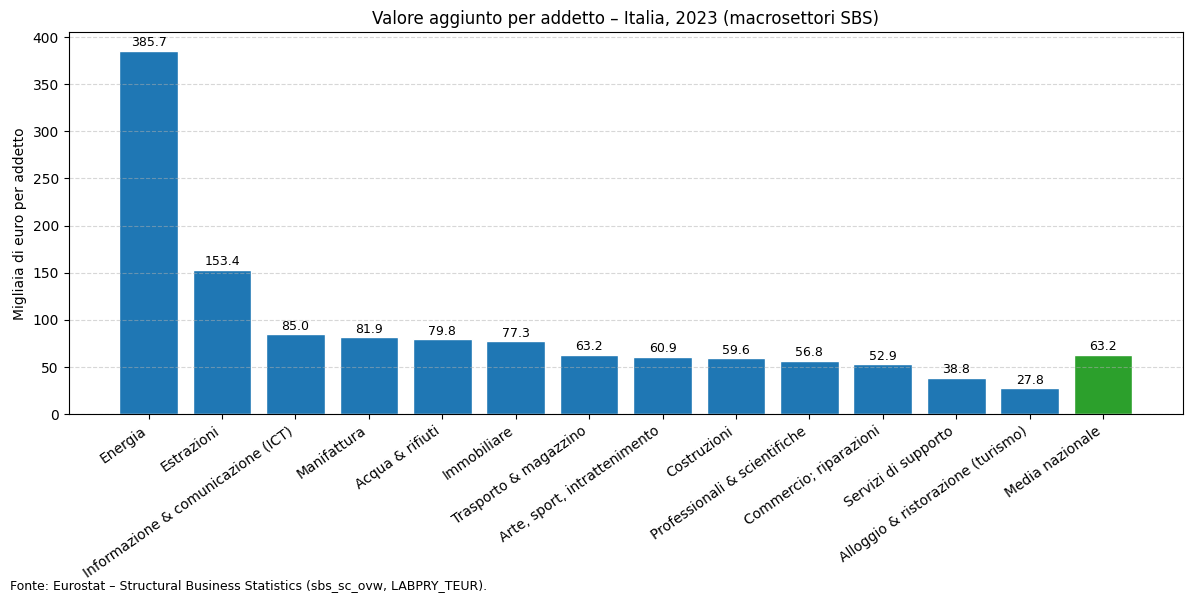

In [0]:
# -*- coding: utf-8 -*-
import eurostat
import pandas as pd
import matplotlib.pyplot as plt

DATASET = "sbs_sc_ovw"
GEO_COL = "geo\\TIME_PERIOD"
YEAR = "2023"
IND = "LABPRY_TEUR"  # kEUR per addetto

# Etichette leggibili per i macro-settori coperti da SBS
labels = {
    "B": "Estrazioni",
    "C": "Manifattura",
    "D": "Energia",
    "E": "Acqua & rifiuti",
    "F": "Costruzioni",
    "G": "Commercio; riparazioni",
    "H": "Trasporto & magazzino",
    "I": "Alloggio & ristorazione (turismo)",
    "J": "Informazione & comunicazione (ICT)",
    "L": "Immobiliare",
    "M": "Professionali & scientifiche",
    "N": "Servizi di supporto",
    "R": "Arte, sport, intrattenimento",
    "S": "Altri servizi"
}
excluded = {"A","K","O","P","Q","T","U"}  # fuori per copertura SBS

# 1) scarica e filtra Italia, indicatore, totale addetti
df = eurostat.get_data_df(DATASET)
base = df[
    (df[GEO_COL] == "IT") &
    (df["indic_sbs"] == IND) &
    (df["size_emp"] == "TOTAL")
].copy()

# 2) tieni solo i macrosettori (codice di una lettera) presenti e non esclusi
base = base[base["nace_r2"].str.len() == 1]
base = base[~base["nace_r2"].isin(excluded)]

# 3) numerico e mapping etichette
base[YEAR] = pd.to_numeric(base[YEAR], errors="coerce")
base = base.dropna(subset=[YEAR])
base["Settore"] = base["nace_r2"].map(labels).fillna(base["nace_r2"])

# 4) media nazionale (totale business economy)
tot = df[
    (df[GEO_COL] == "IT") &
    (df["indic_sbs"] == IND) &
    (df["nace_r2"] == "B-S_X_O_S94") &
    (df["size_emp"] == "TOTAL")
].copy()
tot[YEAR] = pd.to_numeric(tot[YEAR], errors="coerce")
media_val = float(tot[YEAR].iloc[0])

# 5) serie ordinata + riga media
res = base[["Settore", YEAR]].set_index("Settore")[YEAR].sort_values(ascending=False)
res = pd.concat([res, pd.Series({ "Media nazionale": media_val })])

# --- stampa rapida per controllo ---
print("Macroseettori disponibili (Italia, VA per addetto k€) –", YEAR)
print(res.round(1))

# 6) grafico
fig, ax = plt.subplots(figsize=(12,6))
colors = ["#2ca02c" if i=="Media nazionale" else "#1f77b4" for i in res.index]
bars = ax.bar(res.index, res.values, color=colors, edgecolor="white")

# etichette
for b, v in zip(bars, res.values):
    ax.text(b.get_x()+b.get_width()/2, v+1.5, f"{v:.1f}", ha="center", va="bottom", fontsize=9, rotation=0)

ax.set_title(f"Valore aggiunto per addetto – Italia, {YEAR} (macrosettori SBS)")
ax.set_ylabel("Migliaia di euro per addetto")
ax.set_xticklabels(res.index, rotation=35, ha="right")
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
fig.text(0.01, 0.01, "Fonte: Eurostat – Structural Business Statistics (sbs_sc_ovw, LABPRY_TEUR).", ha="left", fontsize=9)
plt.show()
